# Example: div-k-grad-u inverse problem
# WORK IN PROGRESS, DO NOT USE

In [1]:
import numpy as np
from fenics import *
import matplotlib.pyplot as plt
from ufl import replace
from scipy.optimize import minimize

In [2]:
def gaussian_expression(magnitude, mu, sigma_scalar):
    # m*G, where G is gaussian with mean mu and standard deviation sigma
    return Expression('m*exp(-(pow(x[0]-mu_x,2)+pow(x[1]-mu_y,2))/s)',
                      m=magnitude, mu_x=mu[0], mu_y=mu[1], s=sigma_scalar, degree=5)

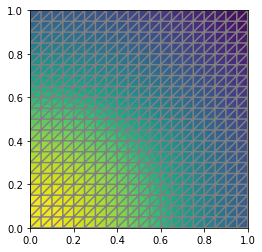

In [3]:
mesh_n = 20
mesh = UnitSquareMesh(mesh_n, mesh_n)
V = FunctionSpace(mesh, 'CG', 1)
plot(mesh)
g = gaussian_expression(1.0, np.array([0., 0.]), 1.)
plot(g,mesh=mesh)

In [4]:
def equally_spaced_points_on_boundary_of_unit_square(num_pts_per_side):
    ss = np.linspace(0., 1., num_pts_per_side)
        
    xx_bot = ss
    yy_bot = np.zeros(len(xx_bot))
    pts_bot = np.array([xx_bot, yy_bot]).T
    
    xx_top = ss
    yy_top = np.ones(len(xx_top))
    pts_top = np.array([xx_top, yy_top]).T

    yy_left = ss[1:-1]
    xx_left = np.zeros(len(yy_left))
    pts_left = np.array([xx_left, yy_left]).T
    
    yy_right = ss[1:-1]
    xx_right = np.ones(len(yy_right))
    pts_right = np.array([xx_right, yy_right]).T
    
    return np.vstack([pts_bot, pts_top, pts_left, pts_right])

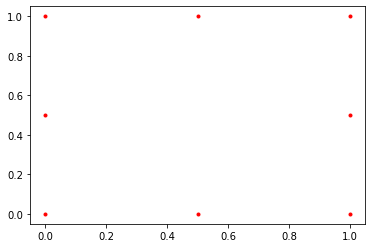

In [5]:
pts = equally_spaced_points_on_boundary_of_unit_square(3)
plt.plot(pts[:,0], pts[:,1], '.r')

In [6]:
def sum_of_partial_directional_derivatives(form, uu, duu):
    # Same as   derivative(form, uu[0], duu[0]) 
    #         + derivative(form, uu[1], duu[1]) 
    #         + ... 
    #         + derivative(form, uu[-1], duu[-1])
    dform = derivative(form, uu[0], duu[0])
    for u, du in zip(uu[1:], duu[1:]):
        dform += derivative(form, u, du)
    return dform

In [7]:
class PoissonInverseProblem:
    def __init__(me, function_space_V, m_true, m0_vec=None, tau=0.1, alpha=1.0, source_points_per_side=3):
        me.V = function_space_V
        me.m_true = m_true
        me.tau = tau   #Regularization = (\tau I + \Delta)^{-2}
        me.alpha = alpha # Regularization parameter. Overall regularization = alpha * (\tau I + \Delta)^{-2}
        me.source_points_per_side=source_points_per_side
        
        
        me.m = Function(me.V) #Parameter
        if m0_vec == None:
            pass
        else:
            me.m.vector()[:] = m0_vec # Parameter
        
        f = Constant(0.0) # Right hand side
        
        # Boundary conditions for each experiment
        me.source_points = equally_spaced_points_on_boundary_of_unit_square(me.source_points_per_side)
        me.sigma = 1./source_points_per_side
        me.num_experiments = me.source_points.shape[0]
        me.all_uD = list()
        for k in range(me.num_experiments):
            me.all_uD.append(gaussian_expression(1.0, me.source_points[k,:], me.sigma)) # Dirichlet data
            
        
#         me.u_D = gaussian_expression(1.0, np.array([0.8, 0.0]), 0.02) # Dirichlet data
        
        me.all_u = [Function(me.V) for _ in range(me.num_experiments)] # State variables
        me.all_p = [Function(me.V) for _ in range(me.num_experiments)] # Adjoint variables
        
        me.dm = Function(me.V) # Function to apply the Hessian to (dm -> Hdm)
        
        me.all_icru = [Function(me.V) for _ in range(me.num_experiments)] # incremental state variables
        me.all_icrp = [Function(me.V) for _ in range(me.num_experiments)] # incremental adjoint variables
        
        # Set up dictionary to specify which functions are derivatives of other functions
        me.derivatives_dictionary = dict()
        me.derivatives_dictionary[me.m] = me.dm
        
        for u, icru in zip(me.all_u, me.all_icru):
            me.derivatives_dictionary[u] = icru
            
        for p, icrp in zip(me.all_p, me.all_icrp):
            me.derivatives_dictionary[p] = icrp
        
        
        ####    Make forward (state) equation form    ####
        
        
#       AFTER:
        me.all_forward_form_base = [(inner(exp(me.m) * grad(u), grad(p))*dx) - (f * p * dx)
                                    for u, p in zip(me.all_u, me.all_p)]


        me.all_forward_form = [replace(fb, {u:TrialFunction(V), p:TestFunction(V)})
                              for fb, u, p in zip(me.all_forward_form_base, me.all_u, me.all_p)]
        
      
        me.all_forward_lhs = [lhs(f) for f in me.all_forward_form]
        me.all_forward_rhs = [rhs(f) for f in me.all_forward_form]
        
        on_boundary_func = lambda x, on_boundary: on_boundary
        
        me.all_bc = [DirichletBC(me.V, uD, on_boundary_func) for uD in me.all_uD]

        me.all_homogenized_bc = [DirichletBC(me.V, Constant(0.0), on_boundary_func) for _ in range(me.num_experiments)]
        me.G = None #Forward operator
        me.G_Solver = None 
        
        
        ####    Make objective function form    ####
        me.all_u_true = [Function(me.V) for _ in range(me.num_experiments)]
                
        nu = FacetNormal(me.V.mesh())

        me.all_misfit_form = [pow(inner(nu, exp(me.m) * grad(u - u_true)), 2) * ds
                             for u, u_true in zip(me.all_u, me.all_u_true)]
        
        #Mass matrix computation
        me.mass_form = TrialFunction(me.V) * TestFunction(me.V) * dx
        me.M = assemble(me.mass_form)
        me.M_solver = LUSolver(me.M)
        
        
        #Regularization computation
        me.regularization_form = 0.5 * (inner(grad(me.m), grad(me.m)) * dx + tau * me.m * me.m * dx)
        me.regularization_gradient_form = derivative(me.regularization_form, me.m, TestFunction(me.V))
        me.regularization_hessian_form = derivative(me.regularization_gradient_form, me.m, TrialFunction(me.V))
        me.R = None #Regularization matrix
        
        # Lagrangian Form
        me.all_lagrangian_form = [misfit_form + forward_form_base 
                                  for misfit_form, forward_form_base
                                  in zip(me.all_misfit_form, me.all_forward_form_base)]

        # Gradient form
        me.all_gradient_form = [derivative(lagrangian_form, me.m, TestFunction(me.V))
                                for lagrangian_form in me.all_lagrangian_form]
        
        # Adjoint form
        me.all_adjoint_form_base = [derivative(lagrangian_form, u, TestFunction(me.V))
                                    for lagrangian_form, u in zip(me.all_lagrangian_form, me.all_u)]
        
        me.all_adjoint_form = [replace(adjoint_form_base, {p:TrialFunction(me.V)})
                               for adjoint_form_base, p in zip(me.all_adjoint_form_base, me.all_p)]
        
        me.all_adjoint_lhs = [lhs(adjoint_form) for adjoint_form in me.all_adjoint_form]
        me.all_adjoint_rhs = [rhs(adjoint_form) for adjoint_form in me.all_adjoint_form]
        me.Gt = None
        me.Gt_solver = None
        me.adjoint_is_computed = False
        
        # Hessian Forms
        
        # Hessian vector product is directional derivative of gradient
        me.all_misfit_hessian_form = [me.total_derivative_of_form(gradient_form)
                                      for gradient_form in me.all_gradient_form]
        
        
        # Incremental forward equation is total derivative of forward equation
        me.all_incremental_forward_form_base = [me.total_derivative_of_form(forward_form_base)
                                                for forward_form_base in me.all_forward_form_base]

        me.all_incremental_forward_form = [replace(ifb, {icru:TrialFunction(me.V), p:TestFunction(me.V)})
                                           for ifb, p, icru in zip(me.all_incremental_forward_form_base,
                                                                   me.all_p, me.all_icru)]
    
        me.all_incremental_forward_rhs = [rhs(iff) for iff in me.all_incremental_forward_form]
        
        # Incremental adjoint equation is total derivative of adjoint equation
        me.all_incremental_adjoint_form_base = [me.total_derivative_of_form(adjoint_form_base)
                                                   for adjoint_form_base in me.all_adjoint_form_base]

        me.all_incremental_adjoint_form = [replace(iafb, {icrp:TrialFunction(me.V)})
                                          for iafb, icrp in zip(me.all_incremental_adjoint_form_base, me.all_icrp)]
    
        me.all_incremental_adjoint_rhs = [rhs(iaf) for iaf in me.all_incremental_adjoint_form]
        
        
        #Solving for u_true
        
        m0_vectcopy = me.m.vector().copy()
        me.update_m(me.m_true.vector().copy(), compute_adjoint=False)
        
        for u, u_true in zip(me.all_u, me.all_u_true):
            u_true.vector()[:] = u.vector()[:].copy()
            
        me.update_m(m0_vectcopy)
        
        
    def total_derivative_of_form(me, form):
        uu = list()
        duu = list()
        for u in me.derivatives_dictionary.keys():
            if u in form.coefficients():
                uu.append(u)
                duu.append(me.derivatives_dictionary[u])
        if uu:
            dform = sum_of_partial_directional_derivatives(form, uu, duu)
        else:
            dform = Constant(0.0) * form
        return dform
    
                                     
    def update_m(me, new_m_vector, compute_adjoint=True):
        m_has_changed = (norm(new_m_vector - me.m.vector()) > 1e-15)
        if m_has_changed:
            me.m.vector()[:] = new_m_vector
            me.make_forward_and_adjoint_solvers()
            me.R = assemble(me.regularization_hessian_form)
            me.solve_forward()
            me.adjoint_is_computed = False
            
        if (compute_adjoint and (not me.adjoint_is_computed)):
            me.solve_adjoint()
            me.adjoint_is_computed = True


    def solve_forward(me):
        for u, forward_rhs, bc in zip(me.all_u, me.all_forward_rhs, me.all_bc):
            b = assemble(forward_rhs)
            bc.apply(b)
            me.G_solver.solve(u.vector(), b)
            
    
    def make_forward_and_adjoint_solvers(me):
        me.G = assemble(me.all_forward_lhs[0])
        me.all_bc[0].apply(me.G)
        me.G_solver = LUSolver(me.G)
        
        me.Gt = assemble(me.all_adjoint_lhs[0])
        me.all_homogenized_bc[0].apply(me.Gt)
        me.Gt_solver = LUSolver(me.Gt)
#         me.Gt_solver = me.G_solver
        
        
    def compute_data_misfit(me):
        data_misfit = 0.0
        for misfit_form in me.all_misfit_form:
            data_misfit += assemble(misfit_form)
        return data_misfit
    
    def compute_objective(me):
        return me.compute_data_misfit() +  me.alpha*assemble(me.regularization_form)
    
    
    def solve_adjoint(me):
        for p, adjoint_rhs, homogenized_bc in zip(me.all_p, me.all_adjoint_rhs, me.all_homogenized_bc):
            b = assemble(adjoint_rhs)
            homogenized_bc.apply(b)
            me.Gt_solver.solve(p.vector(), b)
        
    def compute_riesz_representative(me, v_dual):
        v_riesz = Function(me.V).vector()
        me.M_solver.solve(v_riesz, v_dual)
        return v_riesz
        
    
    def compute_misfit_gradient(me):
        misfit_gradient = assemble(me.all_gradient_form[0])
        for k in range(1, me.num_experiments):
            misfit_gradient += assemble(me.all_gradient_form[k])
        return misfit_gradient
    
    def compute_regularization_gradient(me):
        gr = me.alpha * assemble(me.regularization_gradient_form)
        return gr
    
    def compute_gradient(me):
        gr = me.compute_regularization_gradient()
        gd = me.compute_misfit_gradient()
        gr.axpy(1.0, gd)
        return gr
        
        
    def solve_incremental_forward(me):
        for icru, incremental_forward_rhs, homogenized_bc in zip(me.all_icru, 
                                                                 me.all_incremental_forward_rhs,
                                                                 me.all_homogenized_bc):
            b = assemble(incremental_forward_rhs)
            homogenized_bc.apply(b)
            me.G_solver.solve(icru.vector(), b)

    def solve_incremental_adjoint(me):
        for icrp, incremental_adjoint_rhs, homogenized_bc in zip(me.all_icrp, 
                                                                 me.all_incremental_adjoint_rhs,
                                                                 me.all_homogenized_bc):
            b = assemble(incremental_adjoint_rhs)
            homogenized_bc.apply(b)
    #     G_solver.solve_transpose(v.vector(), b)
            me.Gt_solver.solve(icrp.vector(), b) # symmetric
    
    def apply_data_misfit_hessian_to_vector(me, dm_vector):
        me.dm.vector()[:] = dm_vector
    
        me.solve_incremental_forward()
        me.solve_incremental_adjoint()
        
        Hdm_misfit = assemble(me.all_misfit_hessian_form[0]) 
        for k in range(1, me.num_experiments):
            Hdm_misfit += assemble(me.all_misfit_hessian_form[k])
        return Hdm_misfit
    
    def apply_regularization_hessian_to_vector(me, dm_vector):
        return me.alpha*me.R*dm_vector
        
    
    def apply_hessian_to_vector(me, dm_vector):
        Hdm_misfit = me.apply_data_misfit_hessian_to_vector(dm_vector)
        Hdm_regularization = me.apply_regularization_hessian_to_vector(dm_vector)
        
        Hdm = Hdm_misfit + Hdm_regularization

        return Hdm
        

PIP.compute_data_misfit()= 0.0013684656489835697


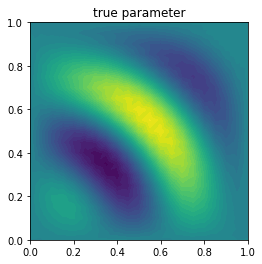

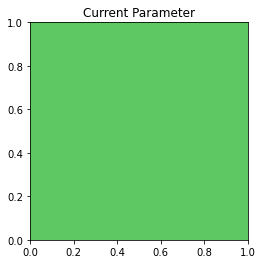

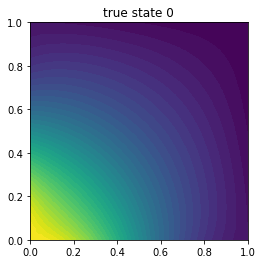

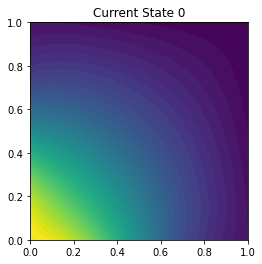

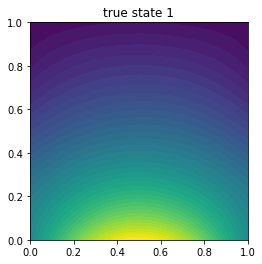

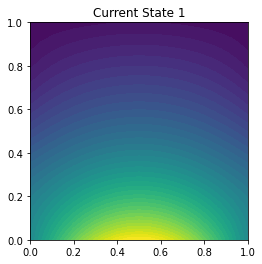

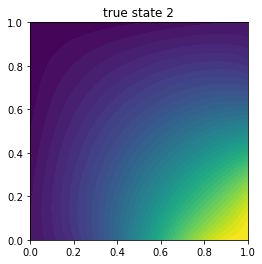

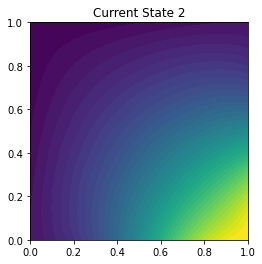

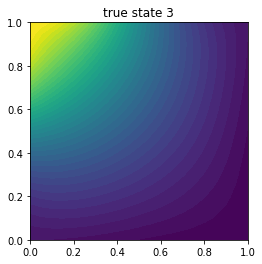

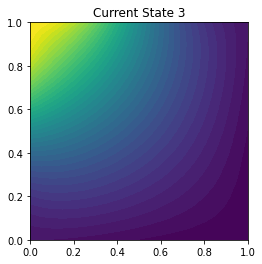

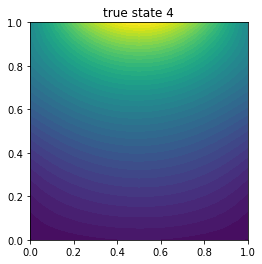

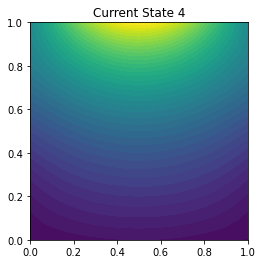

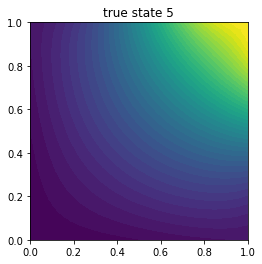

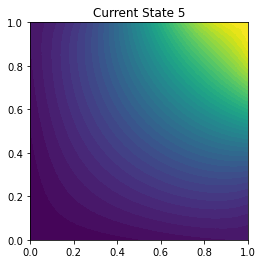

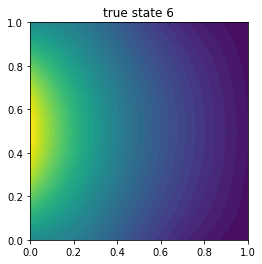

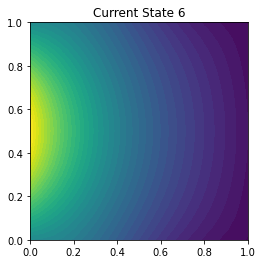

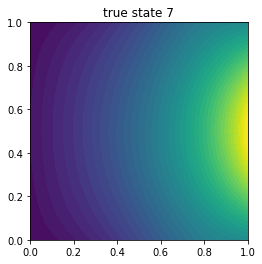

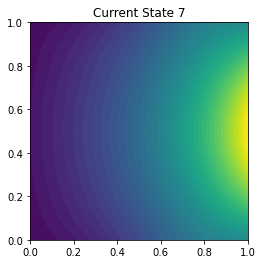

In [8]:
m_true = Expression('x[1]*(1-x[1])*x[0]*(1-x[0])*sin(10*sqrt(pow(x[0],2) + pow(x[1],2)))', degree=5)
m_true_function = project(m_true, V)
PIP = PoissonInverseProblem(V, m_true_function)

print('PIP.compute_data_misfit()=', PIP.compute_data_misfit())


plt.figure()
plot(PIP.m_true)
plt.title("true parameter")

plt.figure()
plot(PIP.m)
plt.title('Current Parameter')

for k in range(PIP.num_experiments):
    plt.figure()
    plot(PIP.all_u_true[k])
    plt.title('true state ' + str(k))
    
    plt.figure()
    plot(PIP.all_u[k])
    plt.title('Current State ' + str(k))

s= 1.0 , err_grad= -0.8962940923462854 , err_hess= 0.8881470609554737
s= 0.1 , err_grad= -0.1724792710317409 , err_hess= 0.16273462763953186
s= 0.01 , err_grad= -0.018343397436646633 , err_hess= 0.0171673833771638
s= 0.001 , err_grad= -0.001845486372918429 , err_hess= 0.0017257030451906152
s= 0.0001 , err_grad= -0.0001846603241844846 , err_hess= 0.00017266047538630738
s= 1e-05 , err_grad= -1.84666299869324e-05 , err_hess= 1.7266919291851803e-05
s= 1e-06 , err_grad= -1.8507303662687531e-06 , err_hess= 1.7295498650681542e-06
s= 1e-07 , err_grad= -1.6638034847691796e-07 , err_hess= 1.624360188367433e-07
s= 1e-08 , err_grad= 3.537729737763675e-07 , err_hess= 5.692470862005128e-07
s= 1e-09 , err_grad= 5.31400600009772e-06 , err_hess= 5.653977487330832e-06
s= 1e-10 , err_grad= 4.199749637251218e-05 , err_hess= 6.580303402330001e-05
s= 1e-11 , err_grad= 2.6408204111486096e-06 , err_hess= 0.0001998103926310339
s= 1e-12 , err_grad= 0.0017246031184617674 , err_hess= 0.004659835052499975
s= 1e-13

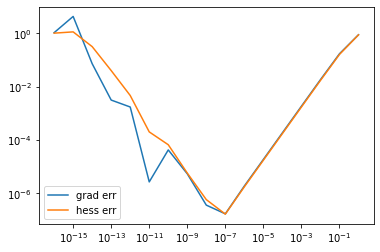

In [9]:
m0 = Expression('cos(x[0]) + x[1]', degree=5)
m0_vector = project(m0, V).vector()

PIP.update_m(m0_vector)

dmE = Expression('sin(x[1]) + x[1]*x[0]', degree=5)
dm_vector = project(dmE, V).vector()


# m0_numpy = np.random.randn(V.dim()) # error big: maybe because of quadrature error near boundary..?
# dm_numpy = np.random.randn(V.dim())

J0 = PIP.compute_objective()
grad0 = PIP.compute_gradient()
dJ = np.dot(grad0[:], dm_vector[:])
Hdm = PIP.apply_hessian_to_vector(dm_vector)

ss = np.logspace(-16, 0, 17)[::-1]
grad_errs = []
hess_errs = []
for k in range(len(ss)):
    s = ss[k]
    m1_vector = m0_vector + s * dm_vector
    PIP.update_m(m1_vector)
    J1 = PIP.compute_objective()
    grad1 = PIP.compute_gradient()
    #dJ1 = np.dot(grad1[:], dm_vector[:])
    
    dJ_diff = (J1 - J0)/s
    err_grad = (dJ - dJ_diff)/dJ_diff
    grad_errs.append(err_grad)
    
    Hdm_diff = (grad1 - grad0)/s
    err_hess = np.linalg.norm(Hdm_diff[:] - Hdm[:])/np.linalg.norm(Hdm_diff[:])
    hess_errs.append(err_hess)
    
    print('s=', s, ', err_grad=', err_grad, ', err_hess=', err_hess)
    #print('s=', s, ', err_grad=', err_grad)
    
plt.loglog(ss, np.abs(grad_errs))
plt.loglog(ss, np.abs(hess_errs))
plt.legend(['grad err', 'hess err'])
#plt.legend(['grad err'])

For the forward problem, we use the inhomogeneous Poisson problem with Dirichlet boundary conditions:
$$\begin{cases}
-\nabla \cdot e^m \nabla u = f & \text{in } \Omega \\
u = 0 & \text{on } \partial \Omega,
\end{cases}$$
where the domain is the unit square, $\Omega=[0,1]^2$, $n$ is the normal to $\partial \Omega$, the parameter is 
$$m(x) = 1.25 + \sin\left(10\|x\|\right),$$
and the source is
$$m(x) = \exp\left(-\frac{\left\|x - p_1\right\|^2}{\sigma^2}\right) + \exp\left(-\frac{\left\|x - p_2\right\|^2}{\sigma^2}\right)$$
where $p_1 = (0.75,0.75)$, $p_2 = (0.25, 0.1)$, $\sigma = 0.1$$.

The weak form for this problem may be written as seeking $u \in H^1_0(\Omega)$ which satisfies
$$0 = g(m,u,v) := \int_\Omega \nabla v \cdot e^m \nabla u dx - \int_\Omega f v dx$$
for all $v \in H^1_0(\Omega)$.

The data misfit function is
$$J_d(m) := \int_{\partial \Omega} \left(\nu \cdot e^m\nabla u(m) - \nu \cdot e^m \nabla u_\text{true}\right)^2 ds.$$

In [8]:
u_true = Function(V)
u_true.vector()[:] = u.vector()[:].copy()

nu = FacetNormal(mesh)

Jd_form = pow(inner(nu, exp(m) * grad(u - u_true)), 2) * ds
# Jd_form = pow(u - u_true, 2) * dx

def compute_data_misfit():
    return assemble(Jd_form)

Jd_true = compute_data_misfit()
print('Jd_true=', Jd_true)

Jd_true= 0.0


In [9]:
def update_m(new_m_vector):
    global G 
    global G_solver
    m.vector()[:] = new_m_vector[:].copy()
    G = assemble(forward_lhs)
    bc.apply(G)
    G_solver = LUSolver(G)

In [10]:
zero_vector = Function(V).vector()

update_m(zero_vector)
solve_forward()
Jd_0 = compute_data_misfit()

print('Jd_0=', Jd_0)

Jd_0= 9.629206722029555e-05


Text(0.5, 1.0, 'u at m=0')

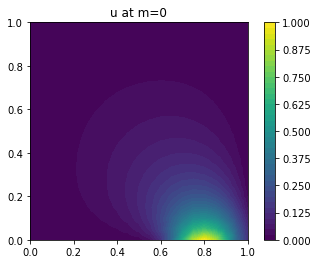

In [11]:
cm1 = plot(u)
plt.colorbar(cm1)
plt.title('u at m=0')

The Lagrangian is
$$\mathcal{L}(m,u,v) := J(m,u,v) + g(m,u,v).$$
We seek an the adjoint variable $v \in H^1_0(\Omega)$ that solves the following adjoint equation
$$0 = a(m,u,v,\widetilde{u}) := \frac{\partial \mathcal{L}}{\partial u}(m,u,v,\widetilde{u}) = 0$$
for all $\widetilde{u} \in H^1_0(\Omega)$.

In [12]:
lagrangian_form = Jd_form + forward_form_base

adjoint_form0 = derivative(lagrangian_form, u, TestFunction(V))

adjoint_form = replace(adjoint_form0, {v:TrialFunction(V)})
adjoint_lhs = lhs(adjoint_form)
adjoint_rhs = rhs(adjoint_form)

Gt = assemble(adjoint_lhs)
bc.apply(Gt)
Gt_solver = LUSolver(Gt)

def solve_adjoint():
    b = assemble(adjoint_rhs)
    homogenized_bc.apply(b)
#     Gt_solver.solve(v.vector(), b)
    G_solver.solve(v.vector(), b) # symmetric

solve_adjoint()

Text(0.5, 1.0, 'adjoint v')

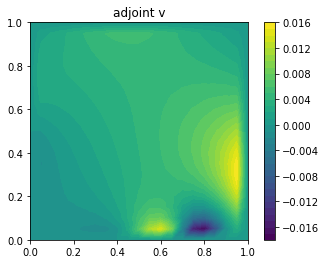

In [13]:
cm = plot(v)
plt.colorbar(cm)
plt.title('adjoint v')

The gradient dual function is given by 
$$g(h) = \frac{\partial \mathcal{L}}{\partial m}(m,u,v)h.$$
The Riesz representative of the gradient is given by the function $g_\text{Riesz}$ satisfying
$$\int_\Omega h g_\text{Riesz} dx = g(h)$$
for all $v$.

In [14]:
mass_form = TrialFunction(V) * TestFunction(V) * dx
M = assemble(mass_form)

M_solver = LUSolver(M)

In [15]:
gradient_form0 = derivative(lagrangian_form, m, TestFunction(V))

def compute_gradient(return_riesz_representative=False):
    g_dual_vector = assemble(gradient_form0)
    
    if return_riesz_representative:
        g_riesz_representative = Function(V)
        M_solver.solve(g_riesz_representative.vector(), g_dual_vector)
        return g_dual_vector, g_riesz_representative
    else:
        return g_dual_vector

g_dual0, g_riesz0 = compute_gradient(return_riesz_representative=True)

Text(0.5, 1.0, 'gradient (riesz representative)')

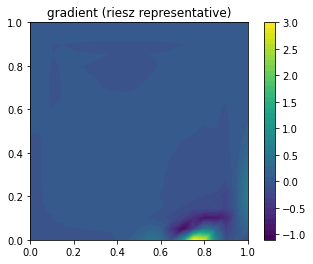

In [16]:
cm = plot(g_riesz0)
plt.colorbar(cm)
plt.title('gradient (riesz representative)')

In [17]:
m_original_numpy_vector = m.vector()[:].copy()

s = 1e-6
dm = Function(V)
dm.vector()[:] = np.random.randn(V.dim()) # perturb m a small bit

update_m(m_original_numpy_vector + s * dm.vector()[:])

solve_forward()
Jd_1 = compute_data_misfit()
solve_adjoint()
g_dual1, g_riesz1 = compute_gradient(return_riesz_representative=True)


update_m(m_original_numpy_vector) # Reset to original m

In [18]:
dJ_diff = (Jd_1 - Jd_0)/s

dJ = np.dot(g_dual0[:], dm.vector()[:])

err_grad = (dJ - dJ_diff)/dJ_diff
print('s=', s, ', err_grad=', err_grad)

s= 1e-06 , err_grad= -7.176519272968872e-05


# Hessian vector products

$$Hp = \frac{dg(m,u,v}{dm}p = \frac{\partial g}{\partial m}p + \frac{\partial g}{\partial u}\underbrace{\frac{du}{dm}p}_{\text{icru}} + \frac{\partial g}{\partial v}\underbrace{\frac{dv}{dm}p}_{\text{icrv}}$$

$$Hp = \frac{dg(m,u,v}{dm}p = \frac{\partial g}{\partial m}p + \frac{\partial g}{\partial u}u_p + \frac{\partial g}{\partial v}v_p$$

In [19]:
p = Function(V) # Function to apply the Hessian to (p -> Hp)
icru = Function(V) # incremental state
icrv = Function(V) # incremental adjoint

# Hessian vector product is directional derivative of gradient
hessian_form0 = (derivative(gradient_form0, m, p)
                + derivative(gradient_form0, u, icru)
                + derivative(gradient_form0, v, icrv))

Take derivative of forward equation to get incremental forward equation
$$0 = \mathcal{G}(m,u)$$
$$0 = \frac{d}{dm}\mathcal{G}(m,u)p = \frac{\partial \mathcal{G}}{\partial m} p + \frac{\partial \mathcal{G}}{\partial u} u_p$$

In [20]:
# Incremental forward equation is total derivative of forward equation
incremental_forward_form0 = (derivative(forward_form0, m, p) 
                             + derivative(forward_form0, u, icru))

incremental_forward_form = replace(incremental_forward_form0, {icru:TrialFunction(V)})
incremental_forward_rhs = rhs(incremental_forward_form)

take derivative of adjoint equation to get incremental adjoint equation
$$0 = \mathcal{A}(m,u,v)$$
$$0 = \frac{d}{dm}\mathcal{A}(m,u,v)p = \frac{\partial \mathcal{A}}{\partial m} p + \frac{\partial \mathcal{A}}{\partial u} u_p + \frac{\partial \mathcal{A}}{\partial v} v_p$$

In [21]:
# Incremental adjoint equation is total derivative of adjoint equation
incremental_adjoint_form0 = (derivative(adjoint_form0, m, p) 
                             + derivative(adjoint_form0, u, icru) 
                             + derivative(adjoint_form0, v, icrv))

incremental_adjoint_form = replace(incremental_adjoint_form0, {icrv:TrialFunction(V)})
incremental_adjoint_rhs = rhs(incremental_adjoint_form)

In [22]:
def solve_incremental_forward():
    b = assemble(incremental_forward_rhs)
    homogenized_bc.apply(b)
    G_solver.solve(icru.vector(), b)

In [23]:
def solve_incremental_adjoint():
    b = assemble(incremental_adjoint_rhs)
    homogenized_bc.apply(b)
#     G_solver.solve_transpose(v.vector(), b)
    G_solver.solve(icrv.vector(), b) # symmetric

In [24]:
def compute_hessian_vector_product(p_vector):
    p.vector()[:] = p_vector[:].copy()
    
    solve_incremental_forward()
    solve_incremental_adjoint()
    Hp = assemble(hessian_form0)
    return Hp

In [25]:
update_m(m_original_numpy_vector) # Reset to original m

solve_forward()
solve_adjoint()
Hdm = compute_hessian_vector_product(dm.vector()[:].copy())

In [26]:
Hdm_diff = (g_dual1[:] - g_dual0[:])/s
err_hess = np.linalg.norm(Hdm_diff - Hdm[:])/np.linalg.norm(Hdm_diff)
print('s=', s, ', err_hess=', err_hess)

s= 1e-06 , err_hess= 1.793916254111672e-06


## Regularization
$$J_R = \frac{1}{2} \left(\int_\Omega \|\nabla m\|^2 dx + 0.1 \int_\Omega m^2 dx\right)$$
$$\frac{d^2 J_R}{dm^2} = R = \Delta_N + 0.1 M$$
where $\Delta_N$ is discretized Neumann Laplacian, and $M$ is mass matrix.
$$M_{ij} := \int_\Omega \phi_i \phi_j dx$$
$$\left(\Delta_N\right)_{ij} := \int_\Omega \nabla \phi_i \cdot \nabla \phi_j dx$$

In [27]:
regularization_form0 = 0.5 * (inner(grad(m), grad(m)) * dx + 0.1 * m * m * dx)
regularization_gradient_form = derivative(regularization_form0, m, TestFunction(V))
regularization_hessian_form = derivative(regularization_gradient_form, m, TrialFunction(V))
R3 = assemble(regularization_hessian_form)

In [29]:
mass_form = TestFunction(V) * TrialFunction(V) * dx
M = assemble(mass_form)

neumann_laplacian_form = inner(grad(TestFunction(V)), grad(TrialFunction(V))) * dx
Delta_N = assemble(neumann_laplacian_form)

# regularization_form = neumann_laplacian_form + 0.1*mass_form
regularization_form = neumann_laplacian_form

def dirichlet_boundary(x, on_boundary):
    return on_boundary

bc_R = DirichletBC(V, Constant(0.0), dirichlet_boundary)

R0 = assemble(regularization_form)
# R = Delta_N + 0.1 * M

bc_R.apply(R0)
R = R0

In [30]:
z = Function(V)
z.vector()[:] = np.random.randn(V.dim())
w = R0 * z.vector() - R * z.vector()
np.linalg.norm(w[:])

0.0

In [31]:
z = Function(V)
z.vector()[:] = np.random.randn(V.dim())
w = R0 * z.vector() - R3 * z.vector()
np.linalg.norm(w[:])

15.12010740258796

## Optimize

In [37]:
a_reg = 1e-5 # regularization parameter

def fun(m_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
        update_m(m_numpy)
#         m.vector()[:] = m_numpy
    solve_forward()
    return compute_data_misfit() + a_reg * assemble(regularization_form0)
    

def jac(m_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
#         m.vector()[:] = m_numpy
        update_m(m_numpy)
        solve_forward()
    solve_adjoint()
    gd = compute_gradient()
    gr = a_reg * assemble(regularization_gradient_form)
    return gd[:] + gr[:]


dm = Function(V)
def hessp(m_numpy, dm_numpy):
    if True:
#     if np.linalg.norm(m_numpy - m.vector()[:]) > 1e-12:
#         m.vector()[:] = m_numpy
        update_m(m_numpy)
        solve_forward()
        solve_adjoint()
    dm.vector()[:] = dm_numpy
    Hd_dm = compute_hessian_vector_product(dm.vector())
    HR_dm = a_reg * (R3 * dm.vector())
    return Hd_dm[:] + HR_dm[:]

In [ ]:
dJ_diff

In [39]:
# soln = minimize(fun, np.zeros(V.dim()), args=(), method='trust-ncg', jac=jac, hessp=hessp, tol=1e-6, callback=None, options={})
soln = minimize(fun, m_true_vector[:], args=(), method='trust-ncg', jac=jac, hessp=hessp, tol=1e-6, callback=None, options={})

In [40]:
soln

     fun: 5.797813351486064e-08
     jac: array([-9.28218127e-11, -1.40529422e-09, -1.41374616e-09, -3.62537209e-09,
       -5.01327143e-09, -2.92685589e-09, -7.57019417e-09, -7.24696502e-09,
       -5.67666565e-09, -5.47756034e-09, -1.24417625e-08, -1.10826260e-08,
       -1.68365980e-09, -7.77784174e-09, -8.19569117e-09, -1.67904657e-08,
       -1.41237362e-08,  2.01741244e-10, -6.51345853e-10, -9.14465969e-09,
       -1.02561065e-08, -2.01449559e-08, -1.64666881e-08,  2.68183764e-09,
        6.40565635e-10,  9.65421357e-10, -9.02174642e-09, -1.05729583e-08,
       -2.28603368e-08, -1.81454374e-08,  4.81265788e-09,  2.59339398e-09,
        1.60049824e-09,  2.37235783e-09, -7.55323703e-09, -8.88455110e-09,
       -2.51940669e-08, -1.96594364e-08,  6.11996671e-09,  4.38278304e-09,
        2.66307665e-09,  2.48351864e-09,  2.79533151e-09, -4.87620943e-09,
       -5.26217583e-09, -2.63425497e-08, -2.02809363e-08,  7.29358227e-09,
        5.89367225e-09,  4.12797649e-09,  3.09392438e-09, 

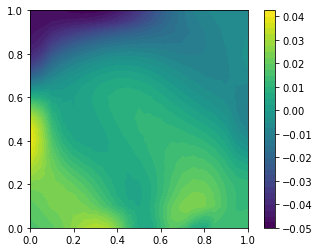

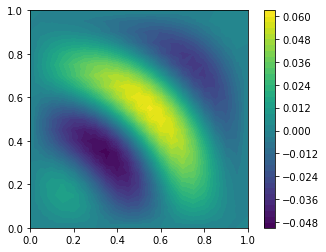

In [41]:
m_reconstructed = Function(V)
m_reconstructed.vector()[:] = soln.x
cm1 = plot(m_reconstructed)
plt.colorbar(cm1)

plt.figure()
cm2 = plot(m_true, mesh=mesh)
plt.colorbar(cm2)